# Train Convolutional Autoencoder (CAE) - Multi-Category

Trains a separate CAE model for each category in the MVTec AD dataset.
Includes automated loop for all 15 categories.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, MVTEC_CATEGORIES, ensure_dirs
from src.data import MVTecDataset, create_mvtec_dataloaders
from src.models import create_cae
from src.training import AutoencoderTrainer, get_optimizer, get_scheduler, EarlyStopping
from src.evaluation import plot_reconstruction_grid, plot_training_curves, plot_roc_curves

ensure_dirs()

## Training Configuration

In [ ]:
CONFIG = {
    'batch_size': 16,
    'num_epochs': 50,  # Adjusted for CPU training duration
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'save_every': 10,
    'patience': 5,
}

# Select categories to train (default: all)
# You can subset this list for testing, e.g., ['bottle', 'cable']
CATEGORIES_TO_TRAIN = MVTEC_CATEGORIES
# CATEGORIES_TO_TRAIN = ['bottle']

print(f"Device: {DEVICE}")
print(f"Categories to train: {CATEGORIES_TO_TRAIN}")

Device: cpu
Categories to train: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


## Training Function

In [ ]:
def train_category(category):
    print(f"\n{'='*50}")
    print(f"Training Category: {category.upper()}")
    print(f"{'='*50}")
    
    # 1. Prepare Data
    try:
        # create_mvtec_dataloaders returns (train_loader, test_loader)
        train_loader, test_loader = create_mvtec_dataloaders(
            category, 
            batch_size=CONFIG['batch_size'], 
            return_mask=True  # Ensure masks are returned for evaluation
        )
    except Exception as e:
        print(f"Skipping {category}: {e}")
        import traceback
        traceback.print_exc()
        return None

    # 2. Initialize Model
    model = create_cae().to(DEVICE)
    optimizer = get_optimizer(model, lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = get_scheduler(optimizer, patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=CONFIG['patience'], mode='min')
    
    trainer = AutoencoderTrainer(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        device=DEVICE,
    )
    
    # 3. Train
    experiment_name = f'cae_{category}'
    history = trainer.fit(
        train_loader=train_loader,
        val_loader=None,  # Unsupervised
        num_epochs=CONFIG['num_epochs'],
        loss_fn=nn.MSELoss(),
        early_stopping=early_stopping,
        save_every=CONFIG['save_every'],
        experiment_name=experiment_name,
        verbose=True
    )
    
    # 4. Evaluate using plotting utilities
    
    # Compute ROC-AUC
    model.eval()
    all_scores, all_labels = [], []
    with torch.no_grad():
        for img, mask, label in test_loader:
            img = img.to(DEVICE)
            score = model.get_reconstruction_error(img, reduction='mean')
            all_scores.extend(score.cpu().numpy())
            all_labels.extend(label.numpy())
            
    try:
        auc = roc_auc_score(all_labels, all_scores)
        print(f"\n{category.upper()} ROC-AUC: {auc:.4f}")
    except ValueError:
        print(f"\nCould not compute AUC (possibly only one class in test set)")
        auc = 0.0
    
    # Save Training Curve
    plot_training_curves(history.to_dict(), title=f'CAE Training - {category}', 
                         save_path=FIGURES_DIR / f'cae_{category}_training.png')
    # Force display
    plt.show()
    plt.close()
    
    # Save Sample Reconstructions
    originals, recons, errors, labels_sample = [], [], [], []
    with torch.no_grad():
        # Get some normal samples
        for img, mask, label in test_loader:
            if len(originals) >= 5: break
            recon = model(img.to(DEVICE))
            err = model.get_reconstruction_error(img.to(DEVICE), reduction='none').mean(dim=1)
            
            # Move to cpu for plotting
            originals.extend(img.cpu())
            recons.extend(recon.cpu())
            errors.extend(err.cpu())
            labels_sample.extend(label.cpu())
            
    plot_reconstruction_grid(
        originals[:4], recons[:4], labels_sample[:4], error_maps=errors[:4],
        title=f'CAE Results - {category}',
        save_path=FIGURES_DIR / f'cae_{category}_reconstruction.png'
    )
    # Force display
    plt.show()
    plt.close()
    
    return {'category': category, 'auc': auc, 'final_loss': history.train_loss[-1]}

## Run Training Loop


Training Category: BOTTLE


Epoch 50 | Train: 0.033990: 100%|██████████| 50/50 [07:16<00:00,  8.72s/it]



Training completed in 7.27 minutes

BOTTLE ROC-AUC: 0.5500


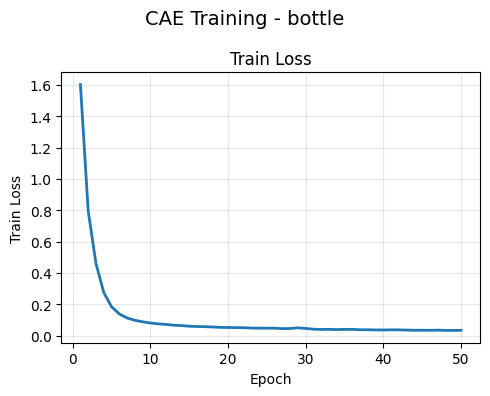

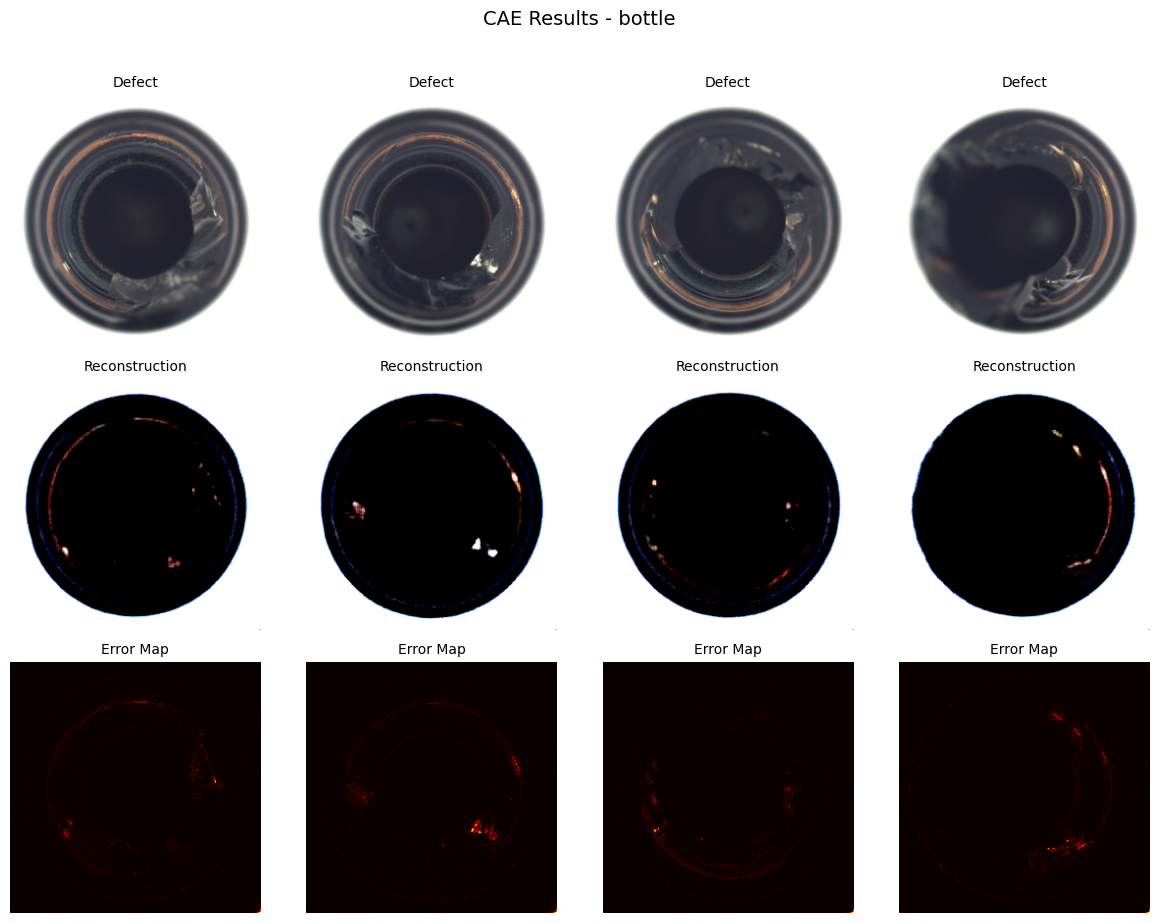


Training Category: CABLE


Epoch 49 | Train: 0.027387:  98%|█████████▊| 49/50 [09:59<00:12, 12.12s/it]

In [ ]:
results = []

for category in CATEGORIES_TO_TRAIN:
    res = train_category(category)
    if res:
        results.append(res)

# Create summary dataframe
df_results = pd.DataFrame(results)
if not df_results.empty:
    print("\n=== Final Results ===")
    display(df_results)
    df_results.to_csv(OUTPUTS_DIR / 'cae_mvtec_results.csv', index=False)